# Fine Tuning

* Data augmentation
* Unfreezing layers
* Adding layers to the head
* Optimizers

In [1]:
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model, model_from_json
tensorflow.keras.__version__

'2.2.4-tf'

## Data Augmentation

Data augmentation is useful in that it expands upon your data

You can read more about reasons why it is helpful here:

[Data Augmentation wit Limited Data](https://www.kdnuggets.com/2018/05/data-augmentation-deep-learning-limited-data.html)

For this we only need to change `train_datagen`

as we don't want to apply these transformations to our validation set

For explanations of the chosen augmentation click the following link

[Data Augmentation Documentation](https://keras.io/preprocessing/image/)

In [2]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

In [3]:
train_generator = train_datagen.flow_from_directory(
    'data/train',
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224))

Found 12894 images belonging to 10 classes.


In [4]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    'data/val',
    shuffle=False,
    class_mode='categorical',
    target_size=(224, 224))

Found 500 images belonging to 10 classes.


In [5]:
conv_base = ResNet50(include_top=False, weights='imagenet')

/home/chris/.miniconda/envs/tf2/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


## Unfreezing Layers

It's easy to unfreeze some layers by specifying `layer.trainable=False` for only some layers

Here we leave the last 4 trainable

In [6]:
# Unfreeze some layers
for layer in conv_base.layers[:-4]:
    layer.trainable = True

## Adding layers to the head

We can also add other layers to the head of our model

Here we add an additional dropout layer

In [7]:
x = conv_base.output
# here we're adding a dropout layer in addtion to the global average pooling and a new dense layer
x = layers.Dropout(0.3)(x)
x = layers.GlobalAveragePooling2D()(x)

predictions = layers.Dense(10, activation='softmax', name='fc3')(x)

In [8]:
model = Model(conv_base.input, predictions)

In [9]:
#model.summary()

## Optimizers

We can also test out other optimaizers although Adam usually works best

In [10]:
opt = tensorflow.keras.optimizers.Adam()
# opt = tensorflow.keras.optimizers.RMSprop()
# opt = tensorflow.keras.optimizers.SGD()
# opt = tensorflow.keras.optimizers.Nadam()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [11]:
history = model.fit_generator(
    generator=train_generator,
    epochs=3,
    validation_data=validation_generator)

Epoch 1/3


W0708 20:44:24.973457 139628346574656 deprecation.py:323] From /home/chris/.miniconda/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


403/403 [==============================] - 243s 603ms/step - loss: 0.9772 - accuracy: 0.7075 - val_loss: 0.9178 - val_accuracy: 0.7220
Epoch 2/3
403/403 [==============================] - 208s 516ms/step - loss: 0.5674 - accuracy: 0.8226 - val_loss: 0.9445 - val_accuracy: 0.7060
Epoch 3/3
403/403 [==============================] - 208s 517ms/step - loss: 0.4779 - accuracy: 0.8453 - val_loss: 0.7232 - val_accuracy: 0.7820


In [12]:
model.save('models/ResNet50_Transfer_model_fine.h5')
model.save_weights('models/ResNet50_Transfer_weights_fine_tune.h5')

In [13]:
with open('models/ResNet50_architecture_fine_tune.json', 'w') as f:
    f.write(model.to_json())

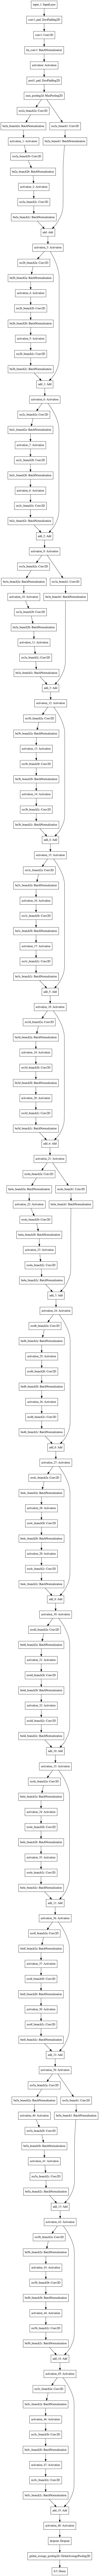

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='plots/models/ResNet50_fine_tune.png')